## importings 

In [340]:
import pandas as pd
import numpy as np

## Chose a ticker

In [341]:
ticker="GOOGL"

## Stocks Data

In [342]:
# get the stock data
from google.cloud import storage
def get_stock_data_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/sorted_final_stock_prices"
    df_stocks = pd.read_csv(path)#add nrows after if you want to select a specific number of row
   
    if ticker:
        df = df_stocks[["date", ticker]]
        df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)
        
    return df


In [343]:
#df_stocks = get_stock_data_from_gcp()

In [344]:
#df_stocks

In [345]:
df_stocks = get_stock_data_from_gcp(ticker=ticker)

/tmp/ipykernel_7111/4215414328.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [346]:
df_stocks

,date,GOOGL
0,1999-11-01,NaN
1,1999-11-02,NaN
2,1999-11-03,NaN
3,1999-11-04,NaN
4,1999-11-05,NaN
...,...,...
5553,2021-11-24,2922.40
5554,2021-11-26,2843.66
5555,2021-11-29,2910.61
5556,2021-11-30,2837.95


## Get the sentiment

In [347]:
# get the data from GCP
from google.cloud import storage
def get_sentiment_news_data_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/final_stocks_sentiment_21221.csv"
    sentiment = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    sentiment = sentiment[['date', 'ticker', 'news_label']]
    sentiment["date"] = pd.to_datetime(sentiment["date"] , infer_datetime_format=True)
    sentiment.set_index(["date"], inplace=True)
    if ticker:
        sentiment_ticker = sentiment[sentiment['ticker'] == ticker]
        sentiment_ticker.drop(columns=['ticker'], inplace=True)
        return sentiment_ticker
    else:
        return sentiment

In [348]:
sentiment = get_sentiment_news_data_from_gcp(ticker=ticker)

/home/frcloers/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [349]:
#sentiment = get_sentiment_news_data_from_gcp()

In [350]:
sentiment

,news_label
date,
2020-11-02,0.000000
2020-11-03,0.000000
2020-11-06,0.500000
2020-11-09,1.000000
2020-11-12,0.500000
...,...
2021-11-28,0.333333
2021-11-29,0.428571
2021-11-30,0.375000


## Get Twitter Data

In [351]:
from google.cloud import storage
def get_twitter_stocks_sentiment_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/Amazon1 twitter_stocks_sentiment.csv"
    
    if ticker=="AMZN":
        path = "gs://stock-news-pred-bucket/Amazon1 twitter_stocks_sentiment.csv"
    if ticker=="GOOGL":
        path = "gs://stock-news-pred-bucket/Google1 twitter_stocks_sentiment.csv"
    if ticker=="MSFT":
        path = "gs://stock-news-pred-bucket/Microsoft1 twitter_stocks_sentiment.csv"
    if ticker=="NFLX":
        path="gs://stock-news-pred-bucket/Netflix1 twitter_stocks_sentiment.csv"
        
    df = pd.read_csv(path, index_col= False)#add nrows after if you want to select a specific number of row
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df.rename(columns={"class_label": "twitter_label"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"] , infer_datetime_format=True)

    return df

In [352]:
df_twitter = get_twitter_stocks_sentiment_from_gcp(ticker=ticker)
df_twitter

,date,twitter_label
0,2020-11-26,0.000000
1,2020-11-27,0.833333
2,2020-11-28,0.200000
3,2020-11-29,0.000000
4,2020-11-30,0.700000
...,...,...
348,2021-11-21,0.285714
349,2021-11-22,0.090909
350,2021-11-23,0.076923
351,2021-11-24,0.173913


## Merging Datasets

In [353]:
def merge_data(df_stocks, df_news, df_twitter):
    df = pd.merge(df_stocks, df_news, on='date', how='outer')
    df_twitter_merge = pd.merge(df, df_twitter, on='date', how='outer')
    df_twitter_merge.rename(columns={"class_label": "news_label"}, inplace= True)
    df_twitter_merge.sort_values(["date"], inplace=True)
    mask = df_twitter_merge["news_label"].notnull()==True
    new_df = df_twitter_merge[mask]
    new_df.iloc[:,1].interpolate(method= "linear", inplace= True)
    #min_date = new_df["date"].min()
    #new_df = df.loc[min_date:,:]
    new_df.fillna(value=-1, inplace=True)
    
    return new_df

In [354]:
df = merge_data(df_stocks, sentiment, df_twitter)

/home/frcloers/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [355]:
df

,date,GOOGL,news_label,twitter_label
5285,2020-11-02,1624.320000,0.000000,-1.0
5286,2020-11-03,1645.660000,0.000000,-1.0
5289,2020-11-06,1759.730000,0.500000,-1.0
5290,2020-11-09,1761.420000,1.000000,-1.0
5293,2020-11-12,1742.820000,0.500000,-1.0
...,...,...,...,...
5650,2021-11-28,2888.293333,0.333333,-1.0
5555,2021-11-29,2910.610000,0.428571,-1.0
5556,2021-11-30,2837.950000,0.375000,-1.0
5557,2021-12-01,2821.030000,0.339623,-1.0


In [356]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# INSTANTIATE THE SCALER
scaler = MinMaxScaler()

# FIT IT ONLY ON AMZN
scaler.fit(df[[ticker]])

# LET'S CREATE A COPY OF MERGED_DF
data_scaled = df.copy()


In [357]:
# AND TRANSFORM ONLY THE AMZN COLUMN
data_scaled[ticker] = scaler.transform(data_scaled[[ticker]])

# NOW LOOK AT DATA_SCALED
data_scaled.tail(20)

,date,GOOGL,news_label,twitter_label
5644,2021-11-13,0.981991,0.333333,0.000000
5645,2021-11-14,0.980893,1.000000,0.500000
5546,2021-11-15,0.979795,0.470588,0.166667
5547,2021-11-16,0.971402,0.395349,0.400000
5548,2021-11-17,0.973893,0.529412,0.333333
5549,2021-11-18,1.000000,0.400000,0.250000
5550,2021-11-19,0.986710,0.536585,0.142857
5646,2021-11-20,0.973961,0.833333,0.000000
5647,2021-11-21,0.961213,0.666667,0.285714
5551,2021-11-22,0.948464,0.500000,0.090909


In [358]:
data_scaled.to_csv(f"scaled_for_{ticker}")

## prepare the LSTM Model

In [359]:
# SETTING THE DATE AS INDEX
data_scaled.set_index(["date"], inplace= True)

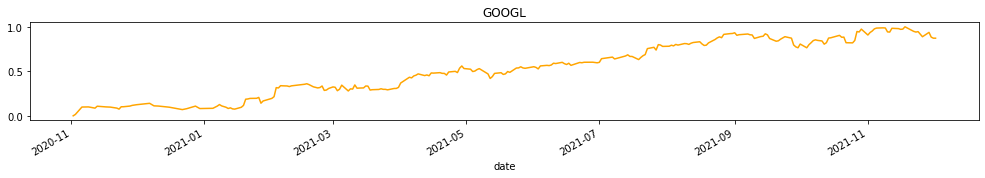

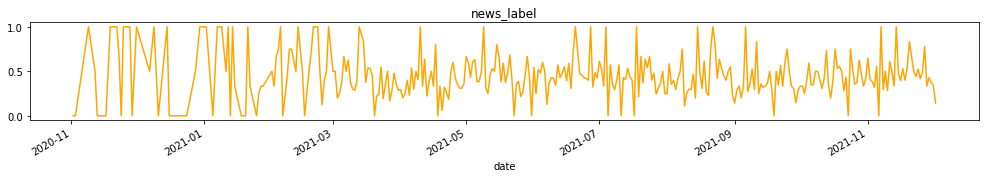

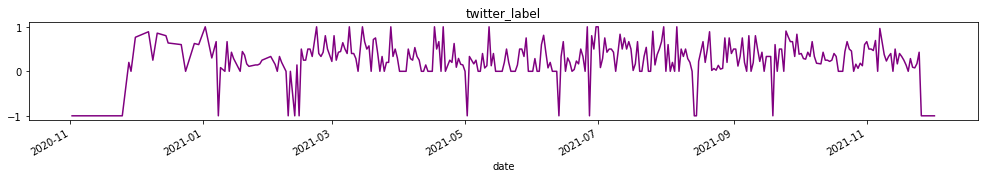

In [360]:
import matplotlib.pyplot as plt
%matplotlib inline

for column in data_scaled.columns:
    if column == ticker: color = "orange"
    if column == "class_label": color = "blue" 
    if column == "twitter_label": color = "purple" 
    data_scaled[column].plot(figsize=(17, 2), color=color)
    plt.title(column)
    plt.show()

In [361]:
data_scaled = data_scaled.drop_duplicates()

## Functions for the input shape of the model

In [362]:
import numpy as np

def subsample_sequence(df, length, HORIZON=0):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length+HORIZON]
    # X_sample = df_sample[random_start: random_start+length]
    # y_sample = df_sample[random_start + length:]
    return df_sample

In [363]:
def split_subsample_sequence(df, length, ticker, HORIZON=1):
    '''Create one single random (X,y) pair'''

    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -HORIZON][ticker] # -1 means the future window
    
    X_sample = df_subsample[0:length -HORIZON]# -1 means the future window
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [364]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, ticker,HORIZON=1, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-HORIZON][ticker]
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

In [365]:
def get_X_y(df, n_sequences, length, ticker): #length = 30, n_sequence = 12, df(12month)
    '''Return a list of samples (X, y)'''
    
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length, ticker)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Train test split

In [366]:
# len of train dataset should be 80%
len_ = int(0.8*data_scaled.shape[0])
df_train = data_scaled[:len_]
df_test = data_scaled[len_:]
print(df_train.shape)
print(df_test.shape)

(273, 3)
(69, 3)


### Check the data 

In [367]:
df_train.head()

,GOOGL,news_label,twitter_label
date,,,
2020-11-02,0.000000,0.0,-1.0
2020-11-03,0.015549,0.0,-1.0
2020-11-06,0.098663,0.5,-1.0
2020-11-09,0.099894,1.0,-1.0
2020-11-12,0.086342,0.5,-1.0


In [368]:
X_train, y_train = get_X_y(df_train, 200, 30, ticker) # 200 sequences of a length of 30 days
X_test, y_test = get_X_y(df_test, 100, 30, ticker) # 200 sequences of a length of 30 days

In [369]:
X_train.shape, y_train.shape

((200, 29, 3), (200,))

In [370]:
X_test.shape, y_test.shape

((100, 29, 3), (100,))

## Predict a baseline

In [371]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 41 %


In [372]:
# Or (better) we predict the last pollution value!
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 2 %


## Model

### imports for the model

In [373]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

### Model Init

In [374]:
def init_model_2():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.005)
    
    model = models.Sequential()
    
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [375]:
model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train,
            validation_split=0.3,
            epochs=5, 
            batch_size=32,
            callbacks=[es], verbose=1)

Epoch 1/5
5/5 [==============================] - 18s 1s/step - loss: 0.0828 - mean_absolute_percentage_error: 48.5960 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 34.0640
Epoch 2/5
5/5 [==============================] - 1s 241ms/step - loss: 0.0189 - mean_absolute_percentage_error: 27.4941 - val_loss: 0.0068 - val_mean_absolute_percentage_error: 24.7805
Epoch 3/5
5/5 [==============================] - 1s 260ms/step - loss: 0.0164 - mean_absolute_percentage_error: 22.3068 - val_loss: 0.0079 - val_mean_absolute_percentage_error: 17.2704
Epoch 4/5
5/5 [==============================] - 1s 271ms/step - loss: 0.0045 - mean_absolute_percentage_error: 11.9895 - val_loss: 0.0034 - val_mean_absolute_percentage_error: 13.9838
Epoch 5/5
5/5 [==============================] - 1s 273ms/step - loss: 0.0173 - mean_absolute_percentage_error: 21.6593 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 25.1691


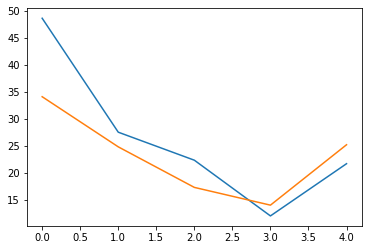

In [376]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['mean_absolute_percentage_error'])
plt.plot(history_2.history['val_mean_absolute_percentage_error'])

In [377]:
res = model_2.evaluate(X_test, y_test, verbose=1)

print(f'MAPE on the test set : {res[1]:.0f} %')

4/4 [==============================] - 0s 64ms/step - loss: 0.0869 - mean_absolute_percentage_error: 30.9899
MAPE on the test set : 31 %


In [378]:
predictions_2 = model_2.predict(X_test)
predictions_2.shape

(100, 1)

In [379]:
unscaled_predictions_2 = scaler.inverse_transform(predictions_2)
unscaled_predictions_2[0:10] # showing 10 predictions in the test set out of 100 

array([[2492.5867],
       [2488.8418],
       [2540.892 ],
       [2486.5623],
       [2547.5994],
       [2486.5623],
       [2488.8418],
       [2483.9287],
       [2501.635 ],
       [2478.0508]], dtype=float32)

In [380]:
error = y_test.reshape(-1,1)-unscaled_predictions_2

In [381]:
#adapt on lenth of df
X, y = get_X_y(data_scaled, len(df), 30, ticker)
X.shape, y.shape

((342, 29, 3), (342,))

In [382]:
predictions_X = model_2.predict(X)
predictions_X[:10]

array([[0.44487885],
       [0.6152737 ],
       [0.62533784],
       [0.2383525 ],
       [0.6678364 ],
       [0.57761323],
       [0.61158144],
       [0.21151757],
       [0.5250323 ],
       [0.41114727]], dtype=float32)

In [383]:
unscaled_predictions_X = scaler.inverse_transform(predictions_X)
unscaled_predictions_X[:10]

array([[2234.894 ],
       [2468.7524],
       [2482.565 ],
       [1951.4469],
       [2540.892 ],
       [2417.0652],
       [2463.685 ],
       [1914.6173],
       [2344.9006],
       [2188.599 ]], dtype=float32)

In [384]:

df_true_pred = df[["date", ticker]]
df_true_pred["predictions"]=unscaled_predictions_X
df_true_pred["ticker"] = ticker

/tmp/ipykernel_7111/2637398465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_true_pred["predictions"]=unscaled_predictions_X


In [385]:
df_true_pred.head()

,date,GOOGL,predictions,ticker
5285,2020-11-02,1624.32,2234.894043,GOOGL
5286,2020-11-03,1645.66,2468.752441,GOOGL
5289,2020-11-06,1759.73,2482.564941,GOOGL
5290,2020-11-09,1761.42,1951.446899,GOOGL
5293,2020-11-12,1742.82,2540.892090,GOOGL


In [386]:
df_true_pred.to_csv(f"LSTM_3features_{ticker}")